# Probabilistic Programming and Bayesian Methods for Hackers

http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

## Chap 1: Introduction to Bayesian Methods

- Philosophy: *You hold a precedent belief. After observing a new evidence, you may update your belief.*
- Different with **frequentist** approach:
  - **frequentist**: probability is the long-run frequency events
  - **bayesian**: probability = measure of belief (confidence) of an event occuring.

### Bayesian inference
- Given a **prior**, an **evidence**, infer the **posterior**.
- Ex. *"Often my code has bugs **[prior]**. My code passed all tests **[evidence]**. Is my code bug-free **[posterior]**?"*
--> YES (prob = 0.8). NO (prob = 0.2)


- Bayes' Theorem: 
$$\begin{align*}
P(A|X) &= \frac{P(X|A) P(A)}{P(X)}\\
&\propto(P(X|A) P(A))
\end{align*}$$

    - $A$: event. $X$: evidence.
    - $P(A)$: prior belief. 
    - $P(A|X)$: posterior belief (updated belief). 

### Probability Distribution

Distribution of a random variable $Z$ is represented by a function, called:
- *Probability mass function (**pmf**)*: if $Z$ is discrete
- *Probability density function (**pdf**)*: if $Z$ is continuous

#### Poisson distribution:
- *Discrete* variables
- Short notation: $Z \sim Poi(\lambda)$
- Probability mass function: $$f_z(z\;|\;\lambda) = \frac{\lambda^z e^{-\lambda}}{z!}, z = 0, 1, 2...$$
- Properties: 
    - $E[Z\;|\;\lambda] = \lambda$
    
#### Exponential distribution
- *Continuous* variables
- Short notation: $Z \sim Exp(\lambda)$
- Probability density function: $$f_z(z\;|\;\lambda) = \lambda e^{-\lambda z}$$
- Properties:
    - $E[Z\;|\;\lambda] = \frac{1}{\lambda}$
    
<u>**Note**</u>: 
- Real-world problems: we only see values of $Z$ while $\lambda$ is hidden.
- Bayesian inference: concerned with beliefs about what $\lambda$ might be (rather not guess the exact value of it)
- *Hyper-parameter* (parent variable): parameter that influences other parameters. For example, $Z \sim Poi(\lambda)$ and $\lambda \sim Exp(\alpha)$, then $\alpha$ is called *hyper-parameter*.

### PyMC3
Just visit the example of text messages, it's really compresensible with vivid visualization.

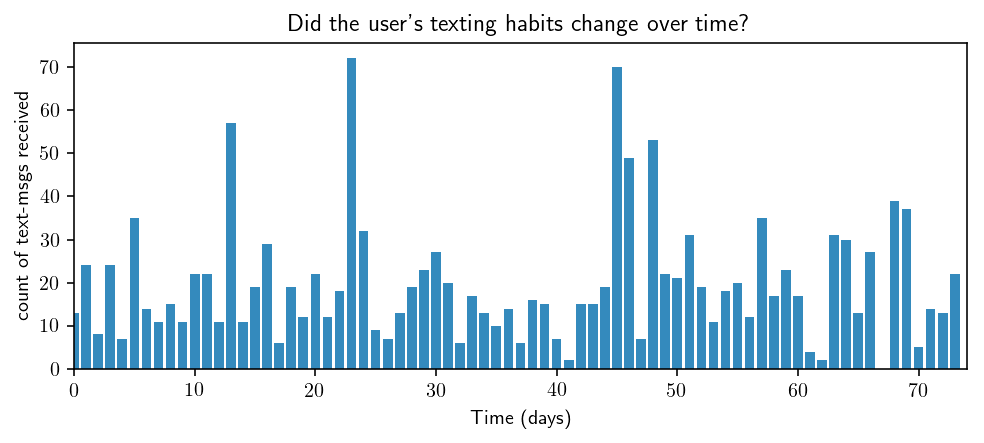

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

%config InlineBackend.figure_format = 'retina'

count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)

figsize(8, 3)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

In [2]:
with pm.Model() as model:
    alpha = 1. / count_data.mean()
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data-1)

with model:
    idxs = np.arange(n_count_data)
    lambda_s = pm.math.switch(tau >= idxs, lambda_1, lambda_2)
    observation = pm.Poisson('obs', lambda_s, observed=count_data)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

100%|██████████| 15000/15000 [00:05<00:00, 2503.98it/s]


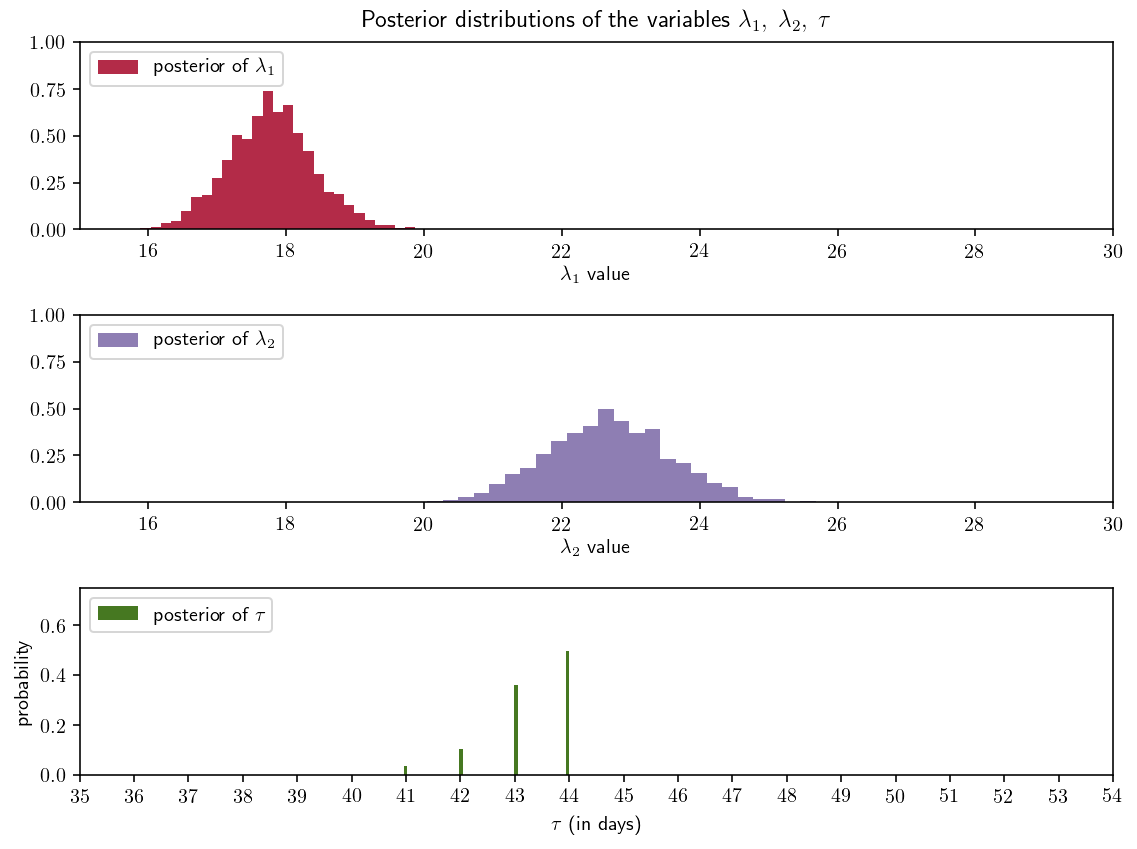

In [3]:
figsize(8, 6)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc='upper left')
plt.title(r'Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$')
plt.xlim([15, 30])
plt.xlabel('$\lambda_1$ value')

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label='posterior of $\lambda_2$', color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel('$\lambda_2$ value')

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r'posterior of $\tau$',
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r'$\tau$ (in days)')
plt.ylabel('probability')
plt.tight_layout()
plt.show()

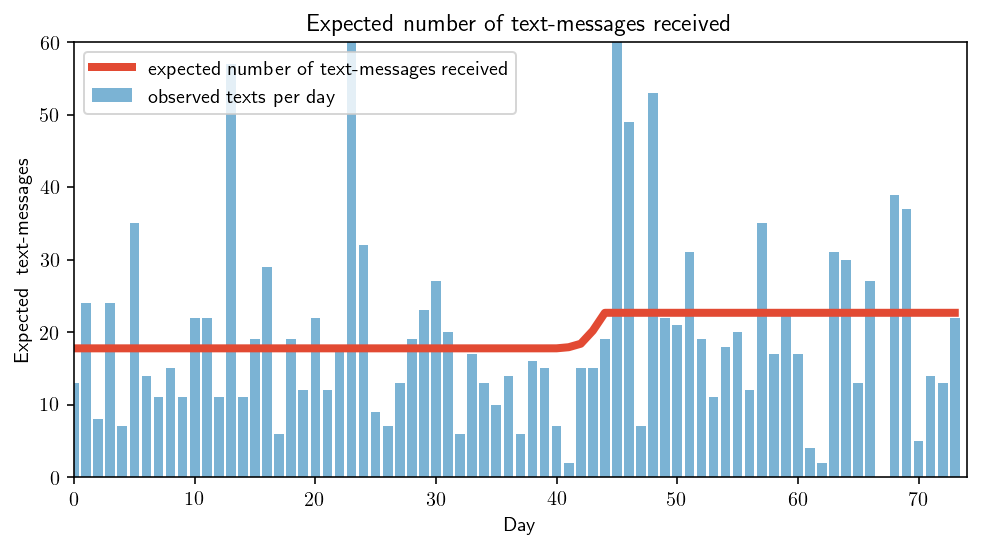

In [4]:
figsize(8, 4)
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")
plt.legend(loc="upper left")
plt.show()